In [1]:
! pip install -q kaggle
!pip install --upgrade onnx

from google.colab import files

files.upload()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 62.3 MB/s eta 0:00:00


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"bradsahw","key":"f6a93f5b1fbe6448cd15de33d0fe2b52"}'}

In [2]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

! chmod 600 ~/.kaggle/kaggle.json

! kaggle datasets list

ref                                                            title                                               size  lastUpdated          downloadCount  voteCount  usabilityRating  
-------------------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
thedrcat/daigt-v2-train-dataset                                DAIGT V2 Train Dataset                              29MB  2023-11-16 01:38:36            797         99  1.0              
carlmcbrideellis/llm-7-prompt-training-dataset                 LLM: 7 prompt training dataset                      41MB  2023-11-15 07:32:56           1249        102  1.0              
thedrcat/daigt-proper-train-dataset                            DAIGT Proper Train Dataset                         119MB  2023-11-05 14:03:25           1245        119  1.0              
muhammadbinimran/housing-price-prediction-data                 Housing

In [3]:
!kaggle datasets download -d andrewmvd/car-plate-detection
!unzip car-plate-detection.zip

 99% 201M/203M [00:06<00:00, 40.1MB/s]
100% 203M/203M [00:06<00:00, 34.9MB/s]
Archive:  car-plate-detection.zip
  inflating: annotations/Cars0.xml   
  inflating: annotations/Cars1.xml   
  inflating: annotations/Cars10.xml  
  inflating: annotations/Cars100.xml  
  inflating: annotations/Cars101.xml  
  inflating: annotations/Cars102.xml  
  inflating: annotations/Cars103.xml  
  inflating: annotations/Cars104.xml  
  inflating: annotations/Cars105.xml  
  inflating: annotations/Cars106.xml  
  inflating: annotations/Cars107.xml  
  inflating: annotations/Cars108.xml  
  inflating: annotations/Cars109.xml  
  inflating: annotations/Cars11.xml  
  inflating: annotations/Cars110.xml  
  inflating: annotations/Cars111.xml  
  inflating: annotations/Cars112.xml  
  inflating: annotations/Cars113.xml  
  inflating: annotations/Cars114.xml  
  inflating: annotations/Cars115.xml  
  inflating: annotations/Cars116.xml  
  inflating: annotations/Cars117.xml  
  inflating: annotations/Cars118.x

In [4]:
mkdir ../content/database

Create a folder called database in the content folder and move the annotations and images folder into the database folder

add data.yaml file to ../content/database/data.yaml

```
train: data_images/train
val: data_images/test
nc: 1
names: [
    'license_plate'
]
```

In [5]:
! pip install --upgrade ultralytics -qq
!pip install GPUtil -qq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 646.0/646.0 kB 9.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [6]:
import warnings
warnings.filterwarnings("ignore")

import os
import shutil
import re
import glob
import subprocess
import random
import yaml
import tqdm
import gc


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns

import IPython.display as display
from IPython.display import Video
from PIL import Image
import cv2

import ultralytics
from ultralytics import YOLO

!pip install easyocr
import easyocr

import xml.etree.ElementTree as xet
from bs4 import BeautifulSoup

import torch
from GPUtil import showUtilization as gpu_usage
from numba import cuda
!pip install pytesseract
import pytesseract

print('ultralytics version: ',ultralytics.__version__)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 908.3/908.3 kB 33.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 27.0 MB/s eta 0:00:00
ultralytics version:  8.0.220


In [7]:
class CFG:

    out_folder = f'../content/working'
    class_name = ['car_plate']
    video_test_path = 'https://docs.google.com/uc?export=download&confirm=&id=1pz68D1Gsx80MoPg-_q-IbEdESEmyVLm-'

    weights = 'yolov8s.pt'
    exp_name = 'car_plate_detection'
    img_size = (240,400)
    vehicles_class = [2, 3, 5, 7]

    epochs = 50
    batch_size = 16
    optimizer = 'auto'
    lr = 1e-3
    lr_factor = 0.01 #lo*lr_f
    weight_decay = 5e-4
    dropout = 0.0
    patience = int(0.7*epochs)
    profile = False
    label_smoothing = 0.0

    vehicle_conf = 0.5
    plate_conf = 0.3
    ocr_conf = 0.1

    seed = 42

In [8]:
def get_bbox(file_path):

    info = xet.parse(file_path)
    root = info.getroot()
    member_object = root.find('object')

    labels_info = member_object.find('bndbox')
    xmin = int(labels_info.find('xmin').text)
    xmax = int(labels_info.find('xmax').text)
    ymin = int(labels_info.find('ymin').text)
    ymax = int(labels_info.find('ymax').text)

    return  xmin, xmax, ymin, ymax

def plot_random_images_from_folder(folder_path, num_images=20, seed=CFG.seed):

    random.seed(seed)

    image_files = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.png', '.jpeg', '.gif'))]

    if len(image_files) < num_images:
        raise ValueError("Not enough images in the folder")

    selected_files = random.sample(image_files, num_images)

    num_cols = 5
    num_rows = (num_images + num_cols - 1) // num_cols
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))

    for i, file_name in enumerate(selected_files):
        img = cv2.imread(os.path.join(folder_path, file_name))

        xmin, xmax, ymin, ymax = get_bbox(file_path=os.path.join('../content/database/annotations',
                                                                 file_name.replace('.png','.xml')))

        start_point = (xmin, ymax)
        end_point = (xmax, ymin)

        img = cv2.rectangle(img, start_point, end_point, (255,0,0), 3)

        if num_rows == 1:
            ax = axes[i % num_cols]
        else:
            ax = axes[i // num_cols, i % num_cols]

        ax.imshow(img)
        ax.axis('off')

    for i in range(num_images, num_rows * num_cols):
        if num_rows == 1:
            fig.delaxes(axes[i % num_cols])
        else:
            fig.delaxes(axes[i // num_cols, i % num_cols])

    plt.tight_layout()
    plt.show()

def parse_xml_tags(data):
    """Parse xml label file, return image file name, and its coordinates as a dictionary
    """
    tags = ['filename', 'width', 'height', 'xmin', 'ymin', 'xmax', 'ymax']
    Bs_data = BeautifulSoup(data, "xml")
    d = dict()

    for t in tags:
        text = Bs_data.find(t).text
        if all(c.isdigit() for c in text):
            d[t] = int(text)
        else:
            d[t] = text
    return d

def convert_xml_txt_yolo(file_path,w_image,h_image):

    with open(file_path,  'r') as f:
        label = parse_xml_tags(f.read())


    xmin = int(label['xmin'])
    xmax = int(label['xmax'])
    ymin = int(label['ymin'])
    ymax = int(label['ymax'])


    x_center = float((xmin+((xmax-xmin)/2))/w_image)
    y_center = float((ymin+((ymax-ymin)/2))/h_image)

    width = float((xmax-xmin)/w_image)
    height = float((ymax-ymin)/h_image)

    str_out = f'0 {x_center} {y_center} {width} {height}'

    return str_out

def display_image(image, print_info = True, hide_axis = False, figsize = (15,15), title=None):
    fig = plt.figure(figsize = figsize)
    if isinstance(image, str):
        img = Image.open(image)

        plt.imshow(img)
    elif isinstance(image, np.ndarray):
        if image.shape[-1] == 3:
            image = image[..., ::-1]
            img = Image.fromarray(image)
            plt.imshow(img)
        else:
            img = np.copy(image)
            plt.imshow(img,cmap = 'gray')

    else:
        raise ValueError("Unsupported image format")

    if print_info:
        print('Type: ', type(img), '\n')
        print('Shape: ', np.array(img).shape, '\n')

    if hide_axis:
        plt.axis('off')
    if title is not None:
        plt.title(title)

    plt.show()

def create_dir(path):

    if not os.path.exists(path):
        os.mkdir(path)

def gpu_report():
    if torch.cuda.is_available():
        num_gpus = torch.cuda.device_count()
        print(f"Number of available GPUs: {num_gpus}")

        if num_gpus > 1:
            train_device, test_device = 0,1

        else:
            train_device, test_device = 0,0

        for i in range(num_gpus):
            gpu_properties = torch.cuda.get_device_properties(i)
            print(f"\nGPU {i}: {gpu_properties.name}")
            print(f"  Total Memory: {gpu_properties.total_memory / (1024**3):.2f} GB")
            print(f"  CUDA Version: {gpu_properties.major}.{gpu_properties.minor}")


    else:
        print("CUDA is not available. You can only use CPU.")
        train_device, test_device = 'cpu', 'cpu'


    print('\n')
    gpu_usage()

    return train_device, test_device

def extract_roi(image, bounding_box):
    x_min, x_max, y_min, y_max = bounding_box
    cropped_image = image[y_min:y_max, x_min:x_max]
    return cropped_image

def free_gpu_cache() -> None:
    print("Initial GPU Usage")
    gpu_usage()


    torch.cuda.empty_cache()


    print("GPU Usage after emptying the cache")
    gpu_usage()


def extract_ocr(roi_img, reader):

    ocr_result = reader.readtext(np.asarray(roi_img), allowlist = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ')
    text_plate = ''
    if len(ocr_result) > 0:

        for item in ocr_result:
            text, conf = item[-2], item[-1]
            text = text if conf > CFG.ocr_conf else ''
            text_plate+=text
    else:
        text_plate, conf = 'unreco_plate', 0

    text_plate = text_plate.lower()

    return text_plate,conf

def inference_inside_roi(df_coords, img, model, device ,display = False):

    bboxs = df_coords[['xmin','xmax','ymin','ymax']].values.astype(int)
    classes = df_coords['class'].values

    df_plate = pd.DataFrame()
    for i,bbox in enumerate(bboxs):

        vehicle_img = extract_roi(img, bbox)

        results = model.predict(vehicle_img,
                        conf = CFG.plate_conf,
                        classes =[0],
                        device = device,
                        verbose = False)

        position_frame = pd.DataFrame(results[0].cpu().numpy().boxes.data,
                                       columns = ['xmin', 'ymin', 'xmax',
                                                  'ymax', 'conf', 'class'])

        position_frame['class'] = position_frame['class'].replace({0:'car_plate'})
        position_frame['plate_number'] = 'unreco_plate'

        position_frame = position_frame.loc[position_frame['conf'] == position_frame['conf'].max(),:]

        position_frame['xmin']+=bbox[0]
        position_frame['xmax']+=bbox[0]
        position_frame['ymin']+=bbox[2]
        position_frame['ymax']+=bbox[2]

        if display:
            display_image(vehicle_img, hide_axis = True, figsize =(10,10), title='Vehicle ROI Image')

        if len(position_frame) > 0:

            plate_bbox = position_frame[['xmin','xmax','ymin','ymax']].values.squeeze().astype(int)
            plate_img = extract_roi(img, plate_bbox)
            text_plate, conf_ocr = extract_ocr(plate_img, reader)
            position_frame['plate_number'] = text_plate

            if display:
                display_image(plate_img, hide_axis = True, figsize =(10,10), title=f'ROI Plate | Nº: {text_plate}')


        position_frame = position_frame[['xmin', 'ymin', 'xmax','ymax' ,'conf', 'class', 'plate_number']]


        df_plate = pd.concat([df_plate, position_frame], axis = 0)

    return img, df_plate

def drawBBox(df_coords, img, title = '' ,thickness=1):

    cords = df_coords[['xmin','xmax','ymin','ymax']].values.astype(int)
    classes = df_coords['class'].values

    for i,detection in enumerate(cords):

        start_point = (detection[0], detection[-1]) # x_min, y_max
        end_point = (detection[1], detection[2]) # x_max, y_min
        class_detected = classes[i]

        if class_detected == 'car_plate':
            number_plate = df_coords['plate_number'].values[i]
            cv2.rectangle(img, start_point, end_point, (0,0,190), thickness)
            cv2.putText(img=img, text=f'{class_detected} ',
                org= (detection[0], detection[2]-20),
                fontFace=cv2.FONT_HERSHEY_TRIPLEX, fontScale=1, color=(0, 0, 255),thickness=2)
            cv2.putText(img=img, text=f'{number_plate}',
                org= (detection[0]-10, detection[-1]+30),
                fontFace=cv2.FONT_HERSHEY_TRIPLEX, fontScale=1, color=(0, 0, 255),thickness=2)
        else:
            cv2.rectangle(img, start_point, end_point, (255,0,0), thickness)

            cv2.putText(img=img, text=f'{class_detected}',
                org= (detection[0], detection[2]-20),
                fontFace=cv2.FONT_HERSHEY_TRIPLEX, fontScale=1, color=(255, 255, 0),thickness=2)

    return img

In [9]:
anoattions_path_xml = glob.glob('../content/database/annotations/*.xml')
image_paths = glob.glob('../content/database/images/*.png')

info = xet.parse(anoattions_path_xml[0])
xet.dump(info)

<annotation>
    <folder>images</folder>
    <filename>Cars154.png</filename>
    <size>
        <width>375</width>
        <height>500</height>
        <depth>3</depth>
    </size>
    <segmented>0</segmented>
    <object>
        <name>licence</name>
        <pose>Unspecified</pose>
        <truncated>0</truncated>
        <occluded>0</occluded>
        <difficult>0</difficult>
        <bndbox>
            <xmin>70</xmin>
            <ymin>197</ymin>
            <xmax>264</xmax>
            <ymax>265</ymax>
        </bndbox>
    </object>
</annotation>


In [10]:
index = np.arange(len(anoattions_path_xml))
np.random.shuffle(index)

val_index = index[:50]
train_index = index[50:]

print('Train Size: ', len(train_index))
print('Valid Size: ', len(val_index))

Train Size:  383
Valid Size:  50


In [11]:
create_dir(CFG.out_folder)
datasets = ['train','valid']
folders = ['images','labels']
for datset in datasets:
    path_1 = CFG.out_folder + f'/{datset}'
    create_dir(path_1)
    for folder in folders:
        path_2 = CFG.out_folder + f'/{datset}/{folder}'

        create_dir(path_2)

        print(path_2)

../content/working/train/images
../content/working/train/labels
../content/working/valid/images
../content/working/valid/labels


In [12]:
for i, img_path in enumerate(image_paths):
    image = cv2.imread(img_path)

    resize_image = cv2.resize(image,CFG.img_size)
    h_image,w_image,_ = image.shape

    label_path = img_path.replace('images','annotations').replace('.png','.xml')

    label_text = convert_xml_txt_yolo(label_path,w_image,h_image)

    text_file_name = img_path.split('/')[-1].replace('.png','.txt')
    img_file_name = img_path.split('/')[-1]

    if i in val_index:
        dataset = 'valid'
    elif i in train_index:
        dataset = 'train'
    elif i in test_index:
        dataset = 'test'

    text_path = f'{CFG.out_folder}/' + dataset +'/'+'/labels/' + text_file_name
    new_img_path = f'{CFG.out_folder}/' + dataset +'/images/'+ img_file_name

    shutil.copy2(img_path,new_img_path)

    text_file = open(text_path, "w")
    text_file.write(label_text)
    text_file.close()

In [13]:
dict_file = {
    'train': os.path.join('train'),
    'val': os.path.join('valid'),
    'nc': len(CFG.class_name),
    'names': CFG.class_name
    }

with open(os.path.join('./', 'data.yaml'), 'w+') as file:
    yaml.dump(dict_file, file)

with open('./data.yaml', 'r') as file:
    data_yaml = yaml.safe_load(file)

print(yaml.dump(data_yaml))

names:
- car_plate
nc: 1
train: train
val: valid



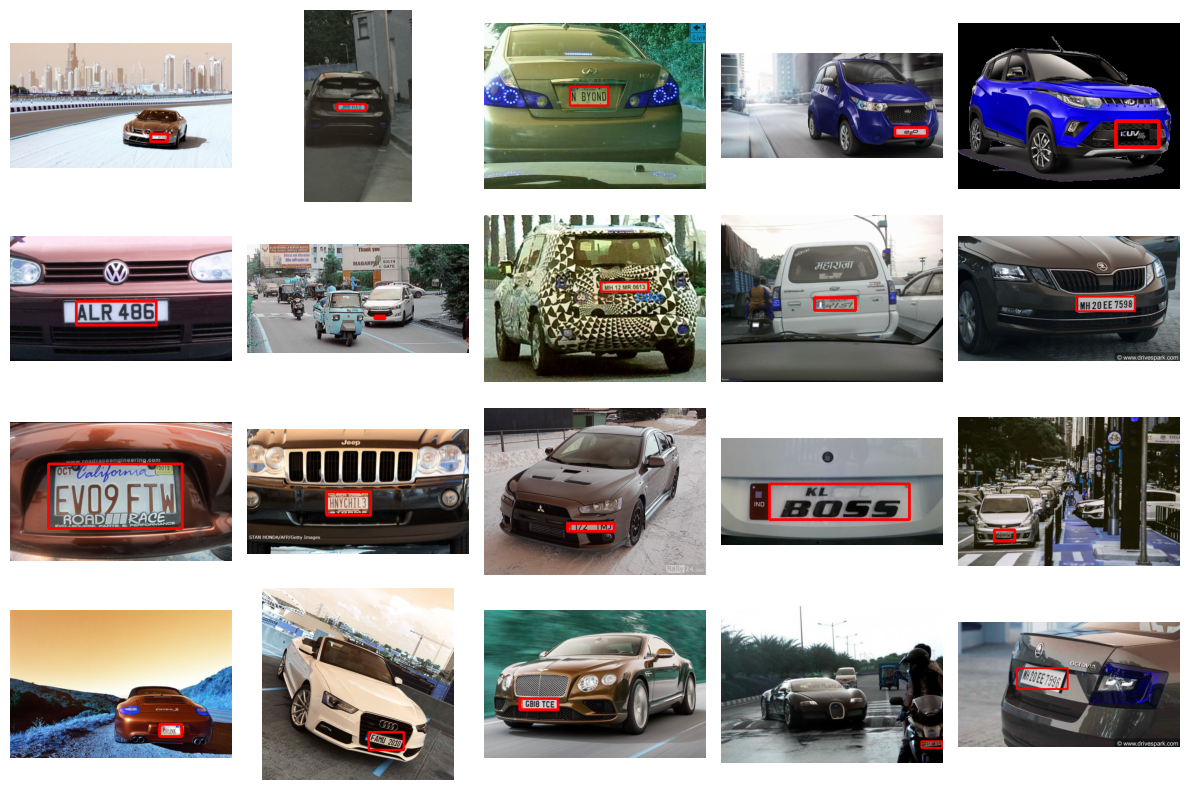

In [14]:
plot_random_images_from_folder(folder_path= '../content/database/images',
                               num_images=20,
                               seed=CFG.seed)

In [17]:
!pip install wandb
! wandb disabled

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 252.8/252.8 kB 20.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.7 MB/s eta 0:00:00
W&B disabled.


In [18]:
plate_model = YOLO(CFG.weights)

100%|██████████| 21.5M/21.5M [00:00<00:00, 320MB/s]


In [20]:
train_device, test_device = gpu_report()
plate_model.to(train_device)

print('\nModel Info')
print('Model: ', CFG.weights)
print('Device: ' ,plate_model.device)

Number of available GPUs: 1

GPU 0: Tesla V100-SXM2-16GB
  Total Memory: 15.77 GB
  CUDA Version: 7.0


| ID | GPU | MEM |
------------------
|  0 |  0% |  6% |

Model Info
Model:  yolov8s.pt
Device:  cuda:0


In [26]:
%%time

plate_model.train(
    data = os.path.join(CFG.out_folder, 'data.yaml'),

    task = 'detect',

    epochs = CFG.epochs,
    batch = CFG.batch_size,
    optimizer = CFG.optimizer,
    lr0 = CFG.lr,
    lrf = CFG.lr_factor,
    weight_decay = CFG.weight_decay,
    dropout = CFG.dropout,
    patience = CFG.patience,
    label_smoothing = CFG.label_smoothing,
    imgsz = 640,
    name = CFG.exp_name,
    seed = CFG.seed,
    profile = False,

    val = True,
    amp = False,
    exist_ok = False,
    resume = False,
    device = train_device,
    verbose = False,
    single_cls = False,
)

Ultralytics YOLOv8.0.220 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla V100-SXM2-16GB, 16151MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=../content/working/data.yaml, epochs=50, patience=35, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=car_plate_detection6, exist_ok=False, pretrained=True, optimizer=auto, verbose=False, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=False, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, l

RuntimeError: ignored

In [79]:
plate_model.export(
    format = 'openvino',
    imgsz = 640,
    half = False,
    int8 = False,
    simplify = False,
    nms = False,
)

Ultralytics YOLOv8.0.220 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla V100-SXM2-16GB, 16151MiB)
Model summary (fused): 168 layers, 11125971 parameters, 0 gradients, 28.4 GFLOPs

PyTorch: starting from 'runs/detect/car_plate_detection/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 5, 8400) (21.5 MB)

ONNX: starting export with onnx 1.15.0 opset 17...
ONNX: export success ✅ 1.0s, saved as 'runs/detect/car_plate_detection/weights/best.onnx' (42.6 MB)

OpenVINO: starting export with openvino 2023.2.0-13089-cfd42bd2cb0-HEAD...
OpenVINO: export success ✅ 0.4s, saved as 'runs/detect/car_plate_detection/weights/best_openvino_model/' (42.8 MB)

Export complete (1.8s)
Results saved to /content/runs/detect/car_plate_detection/weights
Predict:         yolo predict task=detect model=runs/detect/car_plate_detection/weights/best_openvino_model imgsz=640  
Validate:        yolo val task=detect model=runs/detect/car_plate_detection/weights/best_openvino_model imgsz=

'runs/detect/car_plate_detection/weights/best_openvino_model'

move runs folder

In [80]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

!apt-get install tree

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tree is already the newest version (2.0.2-1).
0 upgraded, 0 newly installed, 0 to remove and 15 not upgraded.


In [83]:
res_path = CFG.out_folder + '/runs/detect/' + os.listdir(CFG.out_folder + '/runs/detect/')[-1]
!tree {res_path}

../content/working/runs/detect/car_plate_detection14
├── args.yaml
└── weights

1 directory, 1 file


In [72]:
plots_path = [f for f in os.listdir(res_path) if f.endswith(('.jpg', '.png', '.jpeg'))]

batchs_plot = [f for f in plots_path if 'val_batch' in f]
curves_plot = [f for f in plots_path if 'curve' in f]

print('Examples BBOX ')
for path in batchs_plot:
    print(''.join(path.split('/')))
    display_image(os.path.join(res_path,path), hide_axis = True)

Examples BBOX 


In [64]:
print('Curves Metrics')
for path in curves_plot:
    print(''.join(path.split('/')))
    display_image(os.path.join(res_path,path), hide_axis = True)

Curves Metrics


In [65]:
display_image(os.path.join(res_path,'results.png'))

FileNotFoundError: ignored

<Figure size 1500x1500 with 0 Axes>

In [66]:
vehicle_model = YOLO(CFG.weights)
reader = easyocr.Reader(['en'],  gpu=True if test_device != 'cpu' else False)

plate_model.to(test_device)
vehicle_model.to(test_device)

print('\nModels Info')
print('Plate Model: ', plate_model.device, 'Vehicle Model: ', plate_model.device)

Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete
Models Info
Plate Model:  cuda:0 Vehicle Model:  cuda:0


In [67]:
dict_all_classes = vehicle_model.model.names
dict_classes = {}
for id_class in CFG.vehicles_class:
    dict_classes[id_class] = dict_all_classes[id_class]

dict_classes

{2: 'car', 3: 'motorcycle', 5: 'bus', 7: 'truck'}

In [68]:
test_images = glob.glob('../content/database/images/*.jpeg')

In [69]:
def run_pipeline(path, display=False):

    image = cv2.imread(path)

    if display:
        display_image(image,
                      hide_axis =True,
                      figsize = (10,10),
                      title='Input Image')

    #1
    vehicle_results = vehicle_model.predict(image,
                            conf =CFG.vehicle_conf,
                            classes = CFG.vehicles_class,
                            device = test_device,
                            verbose = False,

                                 )

    df_vehicles = pd.DataFrame(vehicle_results[0].cpu().numpy().boxes.data,
                                   columns = ['xmin', 'ymin', 'xmax',
                                              'ymax','conf', 'class'])
    df_vehicles['class'] = df_vehicles['class'].replace(dict_classes)

    image, df_plates = inference_inside_roi(df_vehicles,
                                                image,
                                                plate_model,
                                                test_device,
                                                display = display)

    df_frame = pd.concat([df_vehicles, df_plates], axis = 0).reset_index(drop=True)

    image = drawBBox(df_frame, image, thickness=5)

    if display:
        display_image(image,
                      hide_axis =True,
                      figsize = (10,10),
                      title='Output Image')

    return df_frame, image


In [70]:
df_frame, out_image  = run_pipeline(path = test_images[11], display=True)

IndexError: ignored

IndexError: ignored

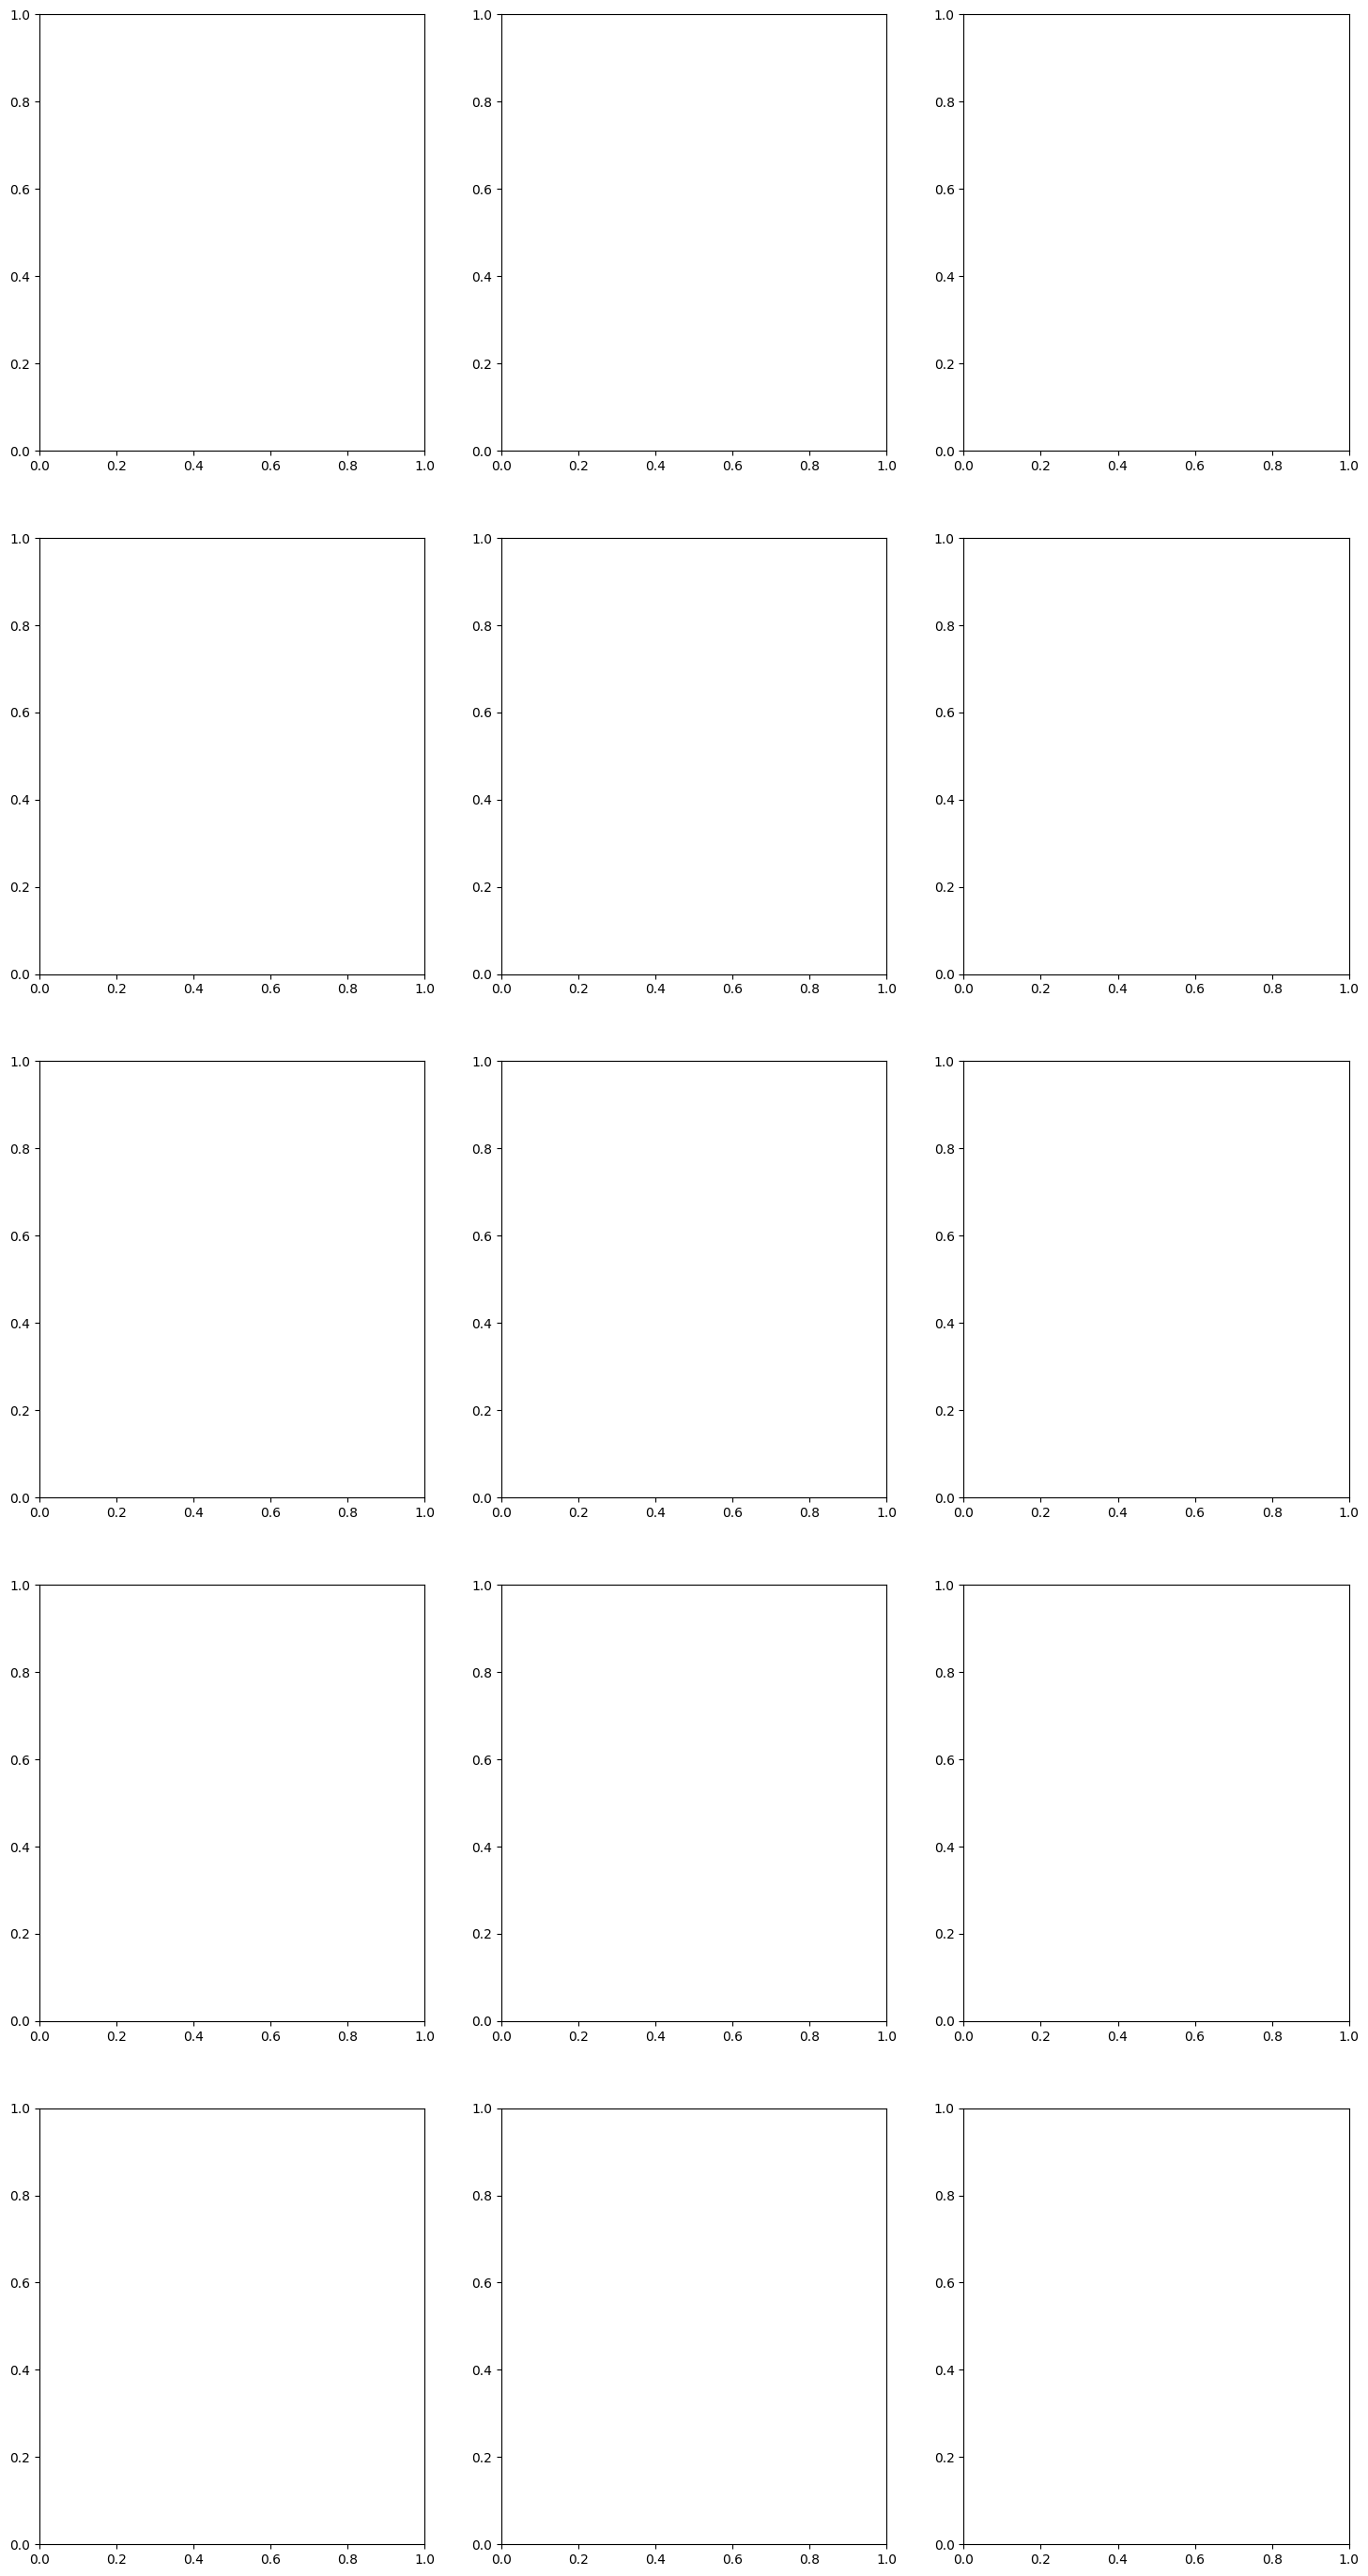

In [71]:
n_inferences = 15

num_cols = 3
num_rows = (n_inferences + num_cols - 1) // num_cols
fig,axes = plt.subplots(num_rows,num_cols, figsize=(num_cols*6, num_rows*7))

for i in range(n_inferences):
    df_frame, out_image  = run_pipeline(path = test_images[i], display=False)

    if num_rows == 1:
        ax = axes[i % num_cols]
    else:
        ax = axes[i // num_cols, i % num_cols]

    out_image = cv2.cvtColor(out_image, cv2.COLOR_BGR2RGB)
    ax.imshow(out_image)

    ax.axis('off')
    ax.set_title(f'Output Image - {i}')